# Advanced Regression Techniques - Machine Learning with Python
## Housing Price Regression Project

#### Tyler Watkins

10-Aug-2018
			
#### Introduction

Accurately predicting housing prices can be a complex endeavor. Just knowing the number of bedrooms and the area zip code isn’t enough. In this notebook I aim to model residential housing prices in Ames, Iowa in an attempt to build an accurate model for predicting housing prices.

I use the Ames Housing dataset which can be found at https://www.kaggle.com/c/house-prices-advanced-regression-techniques. This
dataset and problem were previously launched as a knowledge competition on Kaggle.

The results of this notebook were submitted to the competition and as of 10-Aug-2018 scored in the top 18% of over 4600 entries.


#### Data Exploration and Preparation Process:
- Import data
- Explore best numerical variables
- Remove 2 obvious outliers
- Log transform response variable
- Fix NA issues
- One-hot encode categorical variables


#### Model Process:
- Fit 9 initial models using default parameters
- Select best models and parameter tune
- Choose best model
- Predict on test data and export csv

### Import Libraries and Data

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from scipy import stats
from scipy.stats import norm, skew 
%matplotlib inline

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler

from sklearn.decomposition import PCA

In [16]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

In [17]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [18]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [19]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
#test_data.head(5)

In [21]:
#Save the 'Id' column
train_ID = train_data['Id']
test_ID = test_data['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train_data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)

## Data Exploration and Preparation

### Correlation Map

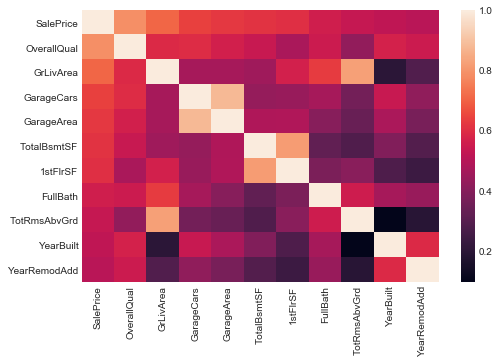

In [22]:
#Correlation map to see how features are correlated with SalePrice
sales_cor = train_data.corr()[['SalePrice']]
sales_cor = sales_cor[sales_cor.SalePrice>0.5]
best_predictors = list(sales_cor.sort_values(['SalePrice'], ascending = False).index)

corrmat = train_data[best_predictors].corr()
plt.subplots(figsize=(8,5))
sns.heatmap(corrmat)

In [23]:
#best_5_predictors = list(sales_cor.sort_values(['SalePrice'], ascending = False).head(5).index)
#sns.pairplot(train_data[best_5_predictors]) 
corrmat

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
SalePrice,1.000,0.791,0.709,0.640,0.623,0.614,0.606,0.561,0.534,0.523,0.507
OverallQual,0.791,1.000,0.593,0.601,0.562,0.538,0.476,0.551,0.427,0.572,0.551
GrLivArea,0.709,0.593,1.000,0.467,0.469,0.455,0.566,0.630,0.825,0.199,0.287
GarageCars,0.640,0.601,0.467,1.000,0.882,0.435,0.439,0.470,0.362,0.538,0.421
GarageArea,0.623,0.562,0.469,0.882,1.000,0.487,0.490,0.406,0.338,0.479,0.372
TotalBsmtSF,0.614,0.538,0.455,0.435,0.487,1.000,0.820,0.324,0.286,0.391,0.291
1stFlrSF,0.606,0.476,0.566,0.439,0.490,0.820,1.000,0.381,0.410,0.282,0.240
FullBath,0.561,0.551,0.630,0.470,0.406,0.324,0.381,1.000,0.555,0.468,0.439
TotRmsAbvGrd,0.534,0.427,0.825,0.362,0.338,0.286,0.410,0.555,1.000,0.096,0.192
YearBuilt,0.523,0.572,0.199,0.538,0.479,0.391,0.282,0.468,0.096,1.000,0.593


Text(0.5,0,'OverallQual')

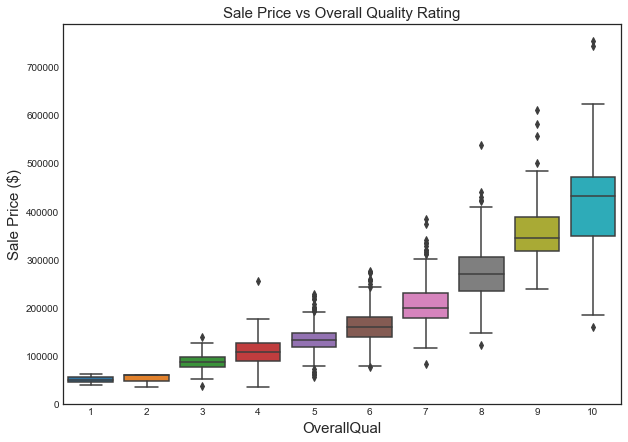

In [24]:
plt.subplots(figsize=(10,7))
sns.boxplot(x="OverallQual", y="SalePrice", data=train_data)
plt.ylabel('Sale Price ($)', fontsize=15)
plt.title('Sale Price vs Overall Quality Rating', fontsize=15)
plt.xlabel('OverallQual', fontsize=15)

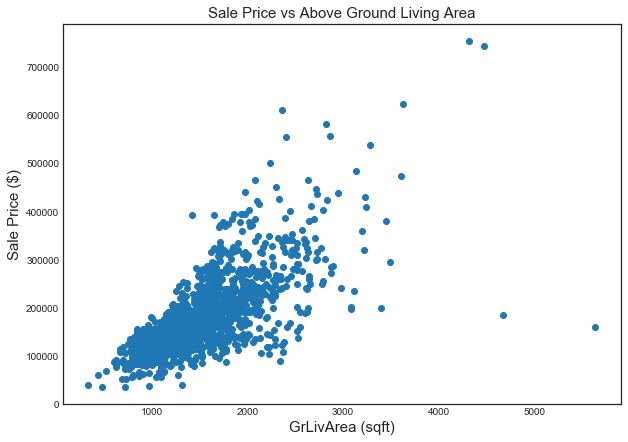

In [25]:
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(train_data['GrLivArea'], train_data['SalePrice'])
plt.title('Sale Price vs Above Ground Living Area', fontsize=15)
plt.ylabel('Sale Price ($)', fontsize=15)
plt.xlabel('GrLivArea (sqft)', fontsize=15)
plt.show()

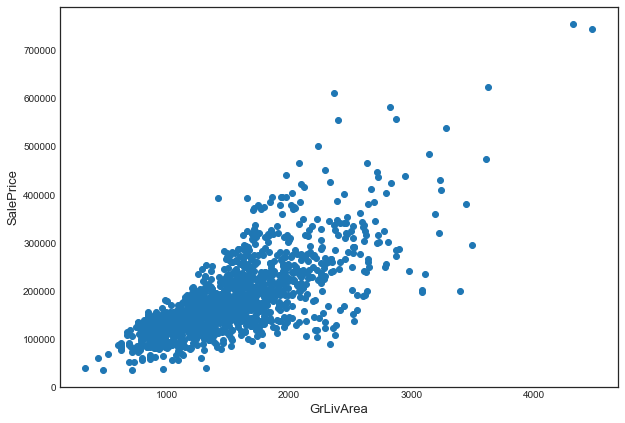

In [26]:
#Deleting outliers
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(train_data['GrLivArea'], train_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Target Variable: Sale Price


 mu = 180932.92 and sigma = 79467.79



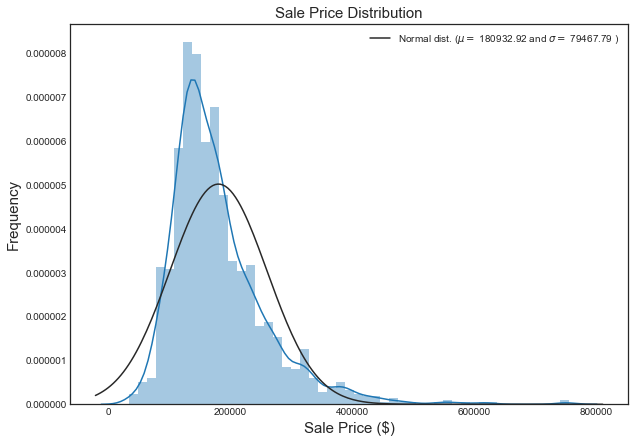

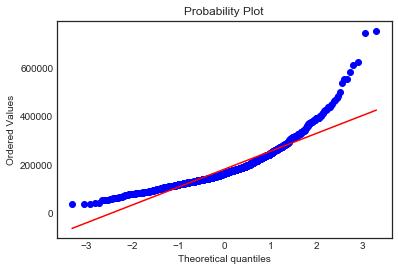

In [27]:
plt.subplots(figsize=(10,7))
sns.distplot(train_data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency', fontsize=15)
plt.title('Sale Price Distribution', fontsize=15)
plt.xlabel('Sale Price ($)', fontsize=15)


#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



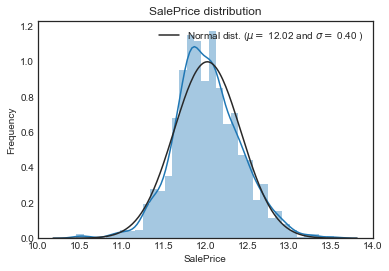

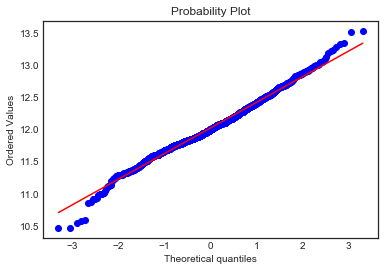

In [28]:
# Log Transform the Target Variable

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

#Check the new distribution 
sns.distplot(train_data['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_data['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)
plt.show()

### Combine train and test data

In [29]:
# Combine features and make y_train
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
y = train_data.SalePrice
y_train = train_data.SalePrice.values
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### Handle Missing  Values

In [30]:
# Check for na values
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5,1,'Percent Missing Data by Feature')

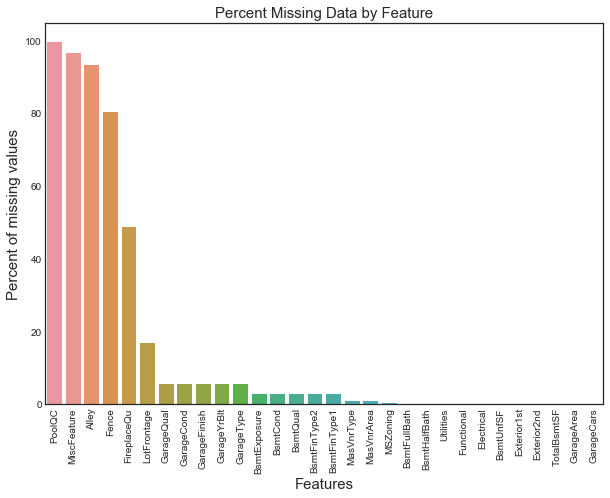

In [31]:
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent Missing Data by Feature', fontsize=15)

In [32]:
# PoolQC : data description says NA means "No Pool". 
# That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

# MiscFeature : data description says NA means "no misc feature"
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

# Alley : data description says NA means "no alley access"
all_data["Alley"] = all_data["Alley"].fillna("None")

# Fence : data description says NA means "no fence"
all_data["Fence"] = all_data["Fence"].fillna("None")

# FireplaceQu : data description says NA means "no fireplace"
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

# LotFrontage : Since the area of each street connected to the house property most likely have a similar area to 
# other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for
# having no basement
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, 
# NaN means that there is no basement.
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and 
# None for the type.
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing 
# values with 'RL'
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
all_data = all_data.drop(['Utilities'], axis=1)

# Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")

# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

# SaleType : Fill in again with most frequent which is "WD"
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

# MSSubClass : Na most likely means No building class. We can replace missing values with None
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [33]:
#Check remaining missing values again if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### One-Hot Encode Data

In [34]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 299)


In [35]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [36]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

## Modelling

In [37]:
num_folds = 5
seed = 42

In [38]:
#Validation function for metric: RMSE(log)
def rmsle_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### First Models

LASSO: 0.169363 (0.004301)
EN: 0.161247 (0.003094)
RR: 0.120100 (0.008799)
KNN: 0.225174 (0.006127)
CART: 0.201056 (0.010111)
AB: 0.170335 (0.006085)
RF: 0.151487 (0.006369)
ET: 0.144099 (0.013884)
GBM: 0.121352 (0.007144)


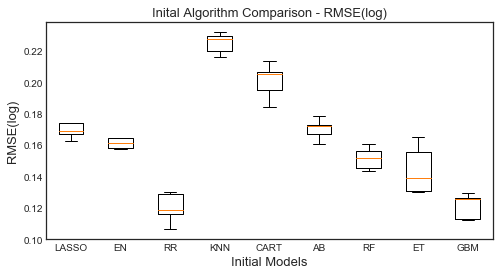

In [39]:
# prepare models
models = []
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('RR', Ridge()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('AB', AdaBoostRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('ET', ExtraTreesRegressor()))
models.append(('GBM', GradientBoostingRegressor()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    score = rmsle_cv(model)
    results.append(score)
    names.append(name)
    msg = "%s: %f (%f)" % (name, score.mean(), score.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.title('Inital Algorithm Comparison - RMSE(log)', fontsize=13)
plt.ylabel('RMSE(log)', fontsize=13)
plt.xlabel('Initial Models', fontsize=13)
plt.show()

LASSO: 0.818903 (0.014925)
EN: 0.835714 (0.014290)
RR: 0.909345 (0.007488)
KNN: 0.680675 (0.013042)
CART: 0.746895 (0.030087)
AB: 0.817190 (0.029706)
RF: 0.866549 (0.010881)
ET: 0.868537 (0.014608)
GBM: 0.907702 (0.007609)


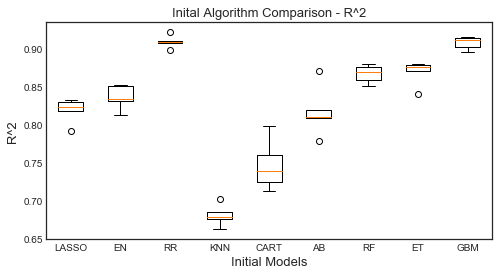

In [40]:
# Comparing several starter models with r^2
models = []
#models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('RR', Ridge()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('AB', AdaBoostRegressor()))
models.append(('RF', RandomForestRegressor()))
models.append(('ET', ExtraTreesRegressor()))
models.append(('GBM', GradientBoostingRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# Compare Algorithms
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.title('Inital Algorithm Comparison - R^2', fontsize=13)
plt.ylabel('R^2', fontsize=13)
plt.xlabel('Initial Models', fontsize=13)
plt.show()

### Parameter Tuning

In [41]:
# Lasso tuning for lambda
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)
model = Lasso()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(train, y_train)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.9160003034841944
0.001


In [42]:
#Enet Tuning
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)
model = ElasticNet()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(train, y_train)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.9174438346933285
0.001


In [43]:
# RR tuning for alpha
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(train, y_train)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.9067727509838801
1.0


In [44]:
## GBM tuning
param_grid = {'n_estimators':[100, 500],'max_depth':[2, 4],'min_samples_leaf':[2, 5]}
model = GradientBoostingRegressor()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(train, y_train)
print(grid.best_score_)
print(grid.best_estimator_.max_depth)
print(grid.best_estimator_.min_samples_leaf)
print(grid.best_estimator_.n_estimators)

0.9113281556122004
2
2
500


### Final Models

In [45]:
# tuned models

# LASSO Regression : This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline
lasso_t = Lasso(alpha =0.001)

#Elastic Net Regression:again made robust to outliers
ENet_t = ElasticNet(alpha=0.001)

# Ridge Regression tuned
RR_t = Ridge(alpha=1)

# GBR tuned
GBoost_t = GradientBoostingRegressor(n_estimators=500, max_depth=2,min_samples_leaf=2)


Lasso: 0.113587 (0.005997)
Enet: 0.112389 (0.006345)
Ridge: 0.120100 (0.008799)
GBoost: 0.119161 (0.007527)


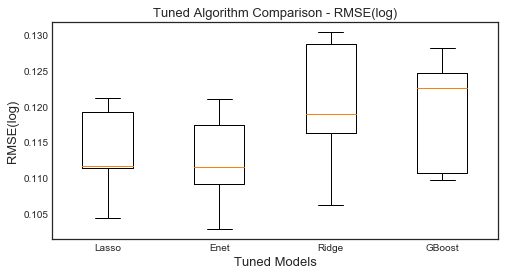

In [46]:
# prepare models
models = []
models.append(('Lasso', lasso_t))
models.append(('Enet', ENet_t))
models.append(('Ridge', RR_t))
models.append(('GBoost', GBoost_t))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    score = rmsle_cv(model)
    results.append(score)
    names.append(name)
    msg = "%s: %f (%f)" % (name, score.mean(), score.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.title('Tuned Algorithm Comparison - RMSE(log)', fontsize=13)
plt.ylabel('RMSE(log)', fontsize=13)
plt.xlabel('Tuned Models', fontsize=13)
plt.show()

Lasso: 0.918875 (0.004135)
Enet: 0.920567 (0.004817)
Ridge: 0.909345 (0.007488)
GBoost: 0.910442 (0.006992)


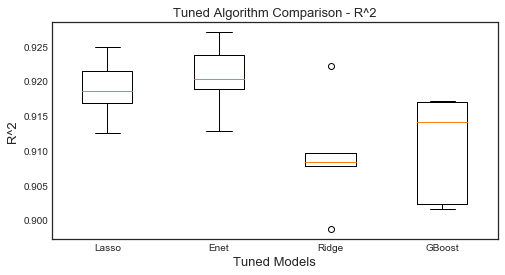

In [47]:
models = []
models.append(('Lasso', lasso_t))
models.append(('Enet', ENet_t))
models.append(('Ridge', RR_t))
models.append(('GBoost', GBoost_t))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# Compare Algorithms
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.title('Tuned Algorithm Comparison - R^2', fontsize=13)
plt.ylabel('R^2', fontsize=13)
plt.xlabel('Tuned Models', fontsize=13)
plt.show()

### Make Submission File

In [48]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [49]:
final_model = ENet_t

In [50]:
final_model.fit(train, y_train)
train_pred = final_model.predict(train)
test_pred = np.expm1(final_model.predict(test.values))
print(rmsle(y_train, train_pred))

0.10068694950391954


In [51]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = test_pred
sub.to_csv('submission.csv',index=False)